In [1]:
'''
1.CIFAR-10データセットの読み込み
'''
from tensorflow.keras import datasets
(x_train, t_train), (x_test, t_test) = datasets.cifar10.load_data()

In [2]:
'''
2.畳み込みネットワークの構築
''' 
from tensorflow.keras import models, layers, optimizers, regularizers

# L2正則化の係数
weight_decay = 1e-4

# CNNを構築
model = models.Sequential()

# (第1層)畳み込み層1 正則化を行う
model.add(
    layers.Conv2D(
        filters=32,                    # フィルターの数は32
        kernel_size=(3,3),             # 3×3のフィルターを使用
        input_shape=x_train.shape[1:], # 入力データの形状
        padding='same',                # ゼロパディングを行う 
        kernel_regularizer=regularizers.l2(weight_decay),
        activation='relu'              # 活性化関数はReLU
        ))

# (第2層)プーリング層1：ウィンドウサイズは2×2
model.add(
    layers.MaxPooling2D(pool_size=(2,2)))

# (第3層)畳み込み層2　正則化を行う
model.add(
    layers.Conv2D(
        filters=128,                # フィルターの数は64
        kernel_size=(3,3),          # 3×3のフィルターを使用
        padding='same',             # ゼロパディングを行う 
        kernel_regularizer=regularizers.l2(weight_decay),
        activation='relu'           # 活性化関数はReLU
        ))

# (第4層)プーリング層2：ウィンドウサイズは2×2
model.add(
    layers.MaxPooling2D(pool_size=(2,2)))

# (第5層)畳み込み層3　正則化を行う
model.add(
    layers.Conv2D(
        filters=256,                # フィルターの数は256
        kernel_size=(3,3),          # 3×3のフィルターを使用
        padding='same',             # ゼロパディングを行う 
        kernel_regularizer=regularizers.l2(weight_decay),
        activation='relu'           # 活性化関数はReLU
        ))

# (第6層)プーリング層2：ウィンドウサイズは2×2
model.add(
    layers.MaxPooling2D(pool_size=(2,2)))

# Flatten
model.add(layers.Flatten())

# ドロップアウト：ドロップアウトは40％
model.add(layers.Dropout(0.4))
 
# （第7層）全結合層
model.add(
    layers.Dense(
        512,                   # ニューロン数は512
        activation='relu'))    # 活性化関数はReLU


# （第8層）出力層
model.add(
    layers.Dense(
        10,                    # 出力層のニューロン数は10
        activation='softmax')) # 活性化関数はソフトマックス

# 学習率
learning_rate = 0.1                  

# Sequentialオブジェクトのコンパイル
model.compile(
    # 損失関数はスパースラベル対応クロスエントロピー誤差
    loss='sparse_categorical_crossentropy',
    # オプティマイザーはSGD
    optimizer=optimizers.SGD(lr=learning_rate),
    # 学習評価として正解率を指定
    metrics=['accuracy'])

# モデルのサマリを表示
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 128)       36992     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 256)         295168    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 256)         0         
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0

In [3]:
%%time
'''
3.学習の実行
'''
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau

# ミニバッチのサイズ
batch_size = 64

# データ拡張
datagen = ImageDataGenerator(
    rescale=1.0/255.0,      # ピクセル値を255で割って正規化する
    validation_split=0.2,   # 20パーセントのデータを検証用にする
    rotation_range=15,      # 15度の範囲でランダムに回転させる
    width_shift_range=0.1,  # 横サイズの0.1の割合でランダムに水平移動
    height_shift_range=0.1, # 縦サイズの0.1の割合でランダムに垂直移動
    horizontal_flip=True,  # 水平方向にランダムに反転、左右の入れ替え
    zoom_range=0.2,         # ランダムに拡大
)

# 訓練データ用のジェネレーターを生成
training_generator = datagen.flow(x_train, t_train,
                                  batch_size=batch_size,
                                  subset='training')      # 訓練用のデータを生成
# 検証データ用のジェネレーターを生成
validation_generator = datagen.flow(x_train, t_train,
                                    batch_size=batch_size,
                                    subset='validation') # 検証用のデータを生成

# 5エポックの間にval_accuracyが改善されなかったら学習率を0.5倍する。
reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy', # 監視対象は検証データの精度
    factor=0.5,             # 学習率を減衰させる割合
    patience=5,             # 監視対象のエポック数
    verbose=1,              # 学習率を下げたときに通知する
    mode='max',             # 最高値を監視する
    min_lr=0.0001           # 学習率の下限
    )

# エポック数
epochs = 100

# 学習を行う
history = model.fit(
    # 拡張データをミニバッチの数だけ生成
    training_generator,
    epochs=epochs,             # エポック数
    verbose=1,                 # 学習の進捗状況を出力する
    validation_data=validation_generator,
    # エポック終了後にreduce_lrをコールバック
    # コールバックはリストで指定する
    callbacks=[reduce_lr]
)

Train for 625 steps, validate for 157 steps
Epoch 1/100
625/625 [==============================] - 148s 237ms/step - loss: 2.0342 - accuracy: 0.2693 - val_loss: 1.6988 - val_accuracy: 0.4034
Epoch 2/100
625/625 [==============================] - 148s 237ms/step - loss: 1.6198 - accuracy: 0.4212 - val_loss: 1.4927 - val_accuracy: 0.4767
Epoch 3/100
625/625 [==============================] - 149s 239ms/step - loss: 1.4603 - accuracy: 0.4851 - val_loss: 1.3242 - val_accuracy: 0.5299
Epoch 4/100
625/625 [==============================] - 150s 241ms/step - loss: 1.3524 - accuracy: 0.5249 - val_loss: 1.2716 - val_accuracy: 0.5547
Epoch 5/100
625/625 [==============================] - 148s 237ms/step - loss: 1.2611 - accuracy: 0.5600 - val_loss: 1.1735 - val_accuracy: 0.5875
Epoch 6/100
625/625 [==============================] - 147s 236ms/step - loss: 1.1894 - accuracy: 0.5892 - val_loss: 1.0954 - val_accuracy: 0.6236
Epoch 7/100
625/625 [==============================] - 148s 237ms/step - l

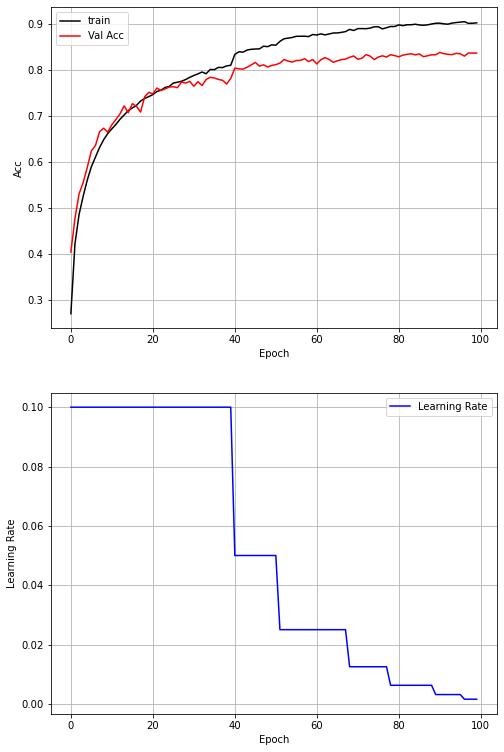

In [15]:
'''
4.損失と正解率（精度）の推移と学習率の推移をグラフにする
'''
# 損失と正解率（精度）の推移をグラフにする

%matplotlib inline
import matplotlib.pyplot as plt

# プロット図のサイズを設定
plt.ﬁgure(ﬁgsize=(8, 13))
# プロット図を縮小して図の間のスペースを空ける
plt.subplots_adjust(wspace=0.2)

# 2×1のグリッドの上部にプロット
plt.subplot(2, 1, 1)
# 訓練データの精度をプロット
plt.plot(
    history.history['accuracy'], label='train', color='black')
# テストデータの精度をプロット
plt.plot(
    history.history['val_accuracy'], label='Val Acc',color='red')
plt.legend()         # 凡例を表示
plt.grid()           # グリッド表示
plt.xlabel('Epoch')  # x軸ラベル
plt.ylabel('Acc')    # y軸ラベル

# 2×1のグリッドの下部にプロット
plt.subplot(2, 1, 2)
# 学習率をプロット
plt.plot(history.history['lr'],
         label='Learning Rate',
         color='blue')
plt.legend()         # 凡例を表示
plt.grid()           # グリッド表示
plt.xlabel('Epoch')  # x軸ラベル
plt.ylabel('Learning Rate')    # y軸ラベル
plt.show()